In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
import re
import numpy as np
import pandas as pd
import json
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv   
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Model, Sequential
import transformers as ppb
import torch

import warnings
warnings.filterwarnings('ignore')

In [0]:
os.chdir("/content/drive/My Drive/MIDS/W266/")
!ls

 bert		        trained_models
 bert_models	        W266
 BERT-NER	       'W266 Project Colab - Binary Twitter.ipynb'
 binary_tweet_dataset  'W266 Project Colab - Drugs.ipynb'
 clinical-BioBERT      'W266 Project Colab - NER Twitter.ipynb'
 drugs_com_dataset     'W266 Project.ipynb'
 ner_tweet_dataset


Helper functions

In [0]:
def annotate_tweets(data_ids, data_ann, i):
  #split tweet into a list of words and punctuation
  tweet = data_ids["tweet"][i]
  tweet = re.sub(r'\n', ' ', tweet) #remove newlines from tweets
  tweet = re.sub(r'"', '', tweet) #remove quotes from tweets
  to_tokenize = '!#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t'
  tweet = re.sub(r'(['+to_tokenize+'])', r' \1 ', tweet) #add spaces in between punctuations
  seq = text_to_word_sequence(tweet, filters='', split=' ', lower=False) #convert tweet to list

  #find the adr associated with the tweet from the annotation file
  tweet_id = data_ids["id"][i]
  adrs = data_ann[data_ann["id"]==tweet_id]["adr"].to_list()
  adrs_list = []
  for adr in adrs:
    adr = re.sub(r'\n', ' ', adr) #remove newlines from tweets
    to_tokenize = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t'
    adr = re.sub(r'(['+to_tokenize+'])', r' \1 ', adr) #add spaces in between punctuations
    adr = text_to_word_sequence(adr, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t', split=' ', lower=False)
    adrs_list.append(adr)

  #build the ner labels
  ner_annotation = []
  for s in seq:
    ner_annotation.append(assign_bio(s, adrs_list))
  
  return(ner_annotation)

In [0]:
def assign_bio(word, adrs_list):
  for adrs in adrs_list:
    for i,adr in enumerate(adrs):
      if word.lower()==adr.lower():
        if i==0:
          return(word+'\tB')
        else:
          return(word+'\tI')
  return(word+'\tO')

Training data

In [0]:
DATA_DIR = "/content/drive/My Drive/MIDS/W266/ner_tweet_dataset/"

In [0]:
#load training data
train_ids =  pd.read_csv(DATA_DIR+'/train_ids_valid.csv')
train_ids.head()

,index,tweet_id,user_id,id,tweet,url,adr_present
0,1,344616533332467713,173701851,vyvanse-51b7c4c75378b9555a2f1ab8,"Vyvanse, commonly known as OCD in a pill.",http://twitter.com/173701851/status/3446165333...,1
1,2,344630199217958912,385562257,vyvanse-51b7d1815378b9555a2f1b0c,@MTV When are you going to do True Life: I am ...,http://twitter.com/385562257/status/3446301992...,1
2,3,342117282585133056,1110475417,cymbalta-51aead545378f924d02efd7c,@upasbook Great read as always. I was on Cymba...,http://twitter.com/1110475417/status/342117282...,1
3,9,351446999637299200,1061562434,seroquel-51d09e2a53785f584a9ae686,I wonder if seroquel /then/ food still equals ...,http://twitter.com/1061562434/status/351446999...,1
4,12,348262745730338817,97567146,rivaroxaban-51c5089353785f584a9a91e5,Rivaroxaban diary day 22. Last tablet taken Tu...,http://twitter.com/97567146/status/34826274573...,1


In [0]:
train_ids.shape[0]

712

In [0]:
train_ids['adr_present'].value_counts()

1    360
0    352
Name: adr_present, dtype: int64

In [0]:
train_ann =  pd.read_csv(DATA_DIR+'/train_tweet_annotations.tsv', delimiter='\t', lineterminator='\n', header=None)
train_ann.columns = ["id","start","end","type","adr","drug1","drug2"]
train_ann.head()

,id,start,end,type,adr,drug1,drug2
0,baclofen-518bf599ac6ab35b4d48099f,60,66,ADR,tired,baclofen,baclofen
1,baclofen-518bf599ac6ab35b4d48099f,67,73,ADR,sleepy,baclofen,baclofen
2,baclofen-518bf599ac6ab35b4d48099f,74,77,ADR,fog,baclofen,baclofen
3,baclofen-51905f6cac6ab35b4d483a24,69,75,ADR,gorked,baclofen,baclofen
4,baclofen-51ae70ba5378f924d02efb33,23,47,ADR,make me a bigger asshole,baclofen,baclofen


In [0]:
#annotate train tweets with ner labels
train_annotations = []
num_data_ids = train_ids.shape[0]
for i in range(num_data_ids):
  train_annotations.append(annotate_tweets(train_ids, train_ann, i))

In [0]:
#save full train dataset to csv file
full_train_tweet_ids_ner = pd.concat([train_ids, pd.DataFrame(np.array(train_annotations),columns=['ner'])], axis=1)
full_train_tweet_ids_ner.to_csv(DATA_DIR+'/full_train_tweet_ids_ner.csv', index=False)

In [0]:
#split into train and dev dataset to csv file
train_tweet_ids_ner, dev_tweet_ids_ner = train_test_split(full_train_tweet_ids_ner, test_size=0.2, random_state=0, stratify=full_train_tweet_ids_ner["adr_present"])
train_tweet_ids_ner.to_csv(DATA_DIR+'train_tweet_ids_ner.csv', index=False)
dev_tweet_ids_ner.to_csv(DATA_DIR+'dev_tweet_ids_ner.csv', index=False)
train_tweet_ids_ner.shape[0], dev_tweet_ids_ner.shape[0]

(569, 143)

In [0]:
#save full train ner labels to tsv file
with open(DATA_DIR+'full_train_tweet_ner_labels.tsv', 'w', newline='\n') as f_output:
  tsv_output = csv.writer(f_output, delimiter='\n')
  for annot in train_annotations:
    tsv_output.writerow(annot)
    tsv_output.writerow('')

In [0]:
#split into train and dev dataset ner labels to tsv file
with open(DATA_DIR+'train_tweet_ner_labels.tsv', 'w', newline='\n') as f_output:
  tsv_output = csv.writer(f_output, delimiter='\n')
  for annot in train_tweet_ids_ner['ner'].to_list():
    tsv_output.writerow(annot)
    tsv_output.writerow('')
with open(DATA_DIR+'dev_tweet_ner_labels.tsv', 'w', newline='\n') as f_output:
  tsv_output = csv.writer(f_output, delimiter='\n')
  for annot in dev_tweet_ids_ner['ner'].to_list():
    tsv_output.writerow(annot)
    tsv_output.writerow('')

In [0]:
train_ner = pd.read_csv(DATA_DIR+'train_tweet_ner_labels.tsv', delimiter='\t', header=None)
train_ner[1].value_counts()

O    11568
B      404
I      356
Name: 1, dtype: int64

In [0]:
train_ner.shape[0]

12328

In [0]:
dev_ner = pd.read_csv(DATA_DIR+'dev_tweet_ner_labels.tsv', delimiter='\t', header=None)
dev_ner[1].value_counts()

O    3039
B     101
I      94
Name: 1, dtype: int64

In [0]:
dev_ner.shape[0]

3234

Load test data

In [0]:
#load test data
test_ids =  pd.read_csv(DATA_DIR+'/test_ids_valid.csv')
test_ids.shape[0]

253

In [0]:
test_ids['adr_present'].value_counts()

1    140
0    113
Name: adr_present, dtype: int64

In [0]:
test_ann =  pd.read_csv(DATA_DIR+'/test_tweet_annotations.tsv', delimiter='\t', lineterminator='\n', header=None)
test_ann.columns = ["id","start","end","type","adr","drug1","drug2"]
test_ann.head()

,id,start,end,type,adr,drug1,drug2
0,avelox-51c3e5a853785f584a9a8c01,76,93,ADR,connective tissue,avelox,avelox
1,avelox-51c3e5a853785f584a9a8c01,94,99,ADR,lungs,avelox,avelox
2,avelox-51c3e5a853785f584a9a8c01,104,111,ADR,thyroid,avelox,avelox
3,baclofen-51b35e355378b9555a2f0709,78,84,ADR,drowsy,baclofen,baclofen
4,baclofen-51b35e355378b9555a2f0709,110,114,ADR,high,baclofen,baclofen


In [0]:
#annotate test tweets with ner labels
test_annotations = []
num_data_ids = test_ids.shape[0]
for i in range(num_data_ids):
  test_annotations.append(annotate_tweets(test_ids, test_ann, i))

In [0]:
#save test dataset to csv file
test_tweet_ids_ner = pd.concat([test_ids, pd.DataFrame(np.array(test_annotations),columns=['ner'])], axis=1)
test_tweet_ids_ner.to_csv(DATA_DIR+'test_tweet_ids_ner.csv', index=False)

In [0]:
#save test ner labels to tsv file
with open(DATA_DIR+'test_tweet_ner_labels.tsv', 'w', newline='\n') as f_output:
  tsv_output = csv.writer(f_output, delimiter='\n')
  for annot in test_annotations:
    tsv_output.writerow(annot)
    tsv_output.writerow('')

In [0]:
test_ner = pd.read_csv(DATA_DIR+'test_tweet_ner_labels.tsv', delimiter='\t', header=None)
test_ner[1].value_counts()

O    5042
B     191
I     124
Name: 1, dtype: int64

In [0]:
test_ner.shape[0]

5357

BERT

In [0]:
!git clone https://github.com/arnavbhandari/clinical-BioBERT.git

Cloning into 'clinical-BioBERT'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 155 (delta 14), reused 0 (delta 0), pack-reused 98
Receiving objects: 100% (155/155), 17.52 MiB | 4.31 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Checking out files: 100% (101/101), done.


In [0]:
BERT_BASE_DIR="/content/drive/My Drive/MIDS/W266/W266/model/cased_L-12_H-768_A-12"
DATA_DIR="/content/drive/My Drive/MIDS/W266/ner_tweet_dataset/bert"
TRAINED_CLASSIFIER="/content/drive/My Drive/MIDS/W266/trained_models/bert_cased_ner"

In [0]:
!ls "$BERT_BASE_DIR"

bert_config.json		     bert_model.ckpt.index  vocab.txt
bert_model.ckpt.data-00000-of-00001  bert_model.ckpt.meta


In [0]:
!ls "$DATA_DIR"

dev.tsv  test.tsv  train.tsv


In [0]:
!ls "$TRAINED_CLASSIFIER"

checkpoint				     model.ckpt-0.data-00000-of-00001
eval					     model.ckpt-0.index
eval_results.txt			     model.ckpt-0.meta
eval.tf_record				     model.ckpt-197.data-00000-of-00001
events.out.tfevents.1584745691.51843a46536a  model.ckpt-197.index
events.out.tfevents.1584746110.51843a46536a  model.ckpt-197.meta
graph.pbtxt				     predict.tf_record
label2id.pkl				     token_test.txt
label_test.txt				     train.tf_record
logits_test.txt


In [0]:
!python ./clinical-BioBERT/run_ner.py \
  --do_train=true \
  --do_eval=true \
  --vocab_file="$BERT_BASE_DIR/vocab.txt" \
  --bert_config_file="$BERT_BASE_DIR/bert_config.json" \
  --init_checkpoint="$BERT_BASE_DIR/bert_model.ckpt" \
  --num_train_epochs=10.0 \
  --data_dir="$DATA_DIR"/ \
  --output_dir="$TRAINED_CLASSIFIER"/


/usr/local/lib/python3.6/dist-packages/absl/flags/_validators.py:359: UserWarning: Flag --task_name has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  'command line!' % flag_name)


W0320 23:37:16.173759 139909926385536 module_wrapper.py:139] From ./clinical-BioBERT/run_ner.py:473: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0320 23:37:16.174030 139909926385536 module_wrapper.py:139] From ./clinical-BioBERT/run_ner.py:473: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0320 23:37:16.174254 139909926385536 module_wrapper.py:139] From /content/drive/My Drive/MIDS/W266/clinical-BioBERT/modeling.py:92: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorfl

In [0]:
!python ./clinical-BioBERT/biocodes/ner_detokenize.py \
  --token_test_path="$TRAINED_CLASSIFIER/token_test.txt" \
  --label_test_path="$TRAINED_CLASSIFIER/label_test.txt" \
  --answer_path="$DATA_DIR/test.tsv" \
  --output_dir="TRAINED_CLASSIFIER"

5357 5557
Error! : len(ans['labels']) != len(bert_pred['labels']) : Please report us
Traceback (most recent call last):
  File "./clinical-BioBERT/biocodes/ner_detokenize.py", line 88, in <module>
    detokenize(args.answer_path, args.token_test_path, args.label_test_path, args.output_dir)
  File "./clinical-BioBERT/biocodes/ner_detokenize.py", line 77, in detokenize
    raise
RuntimeError: No active exception to reraise


In [0]:
!ls -la "$TRAINED_CLASSIFIER"

total 2564206
-rw------- 1 root root        128 Mar 20 23:21 checkpoint
drwx------ 2 root root       4096 Mar 20 23:21 eval
-rw------- 1 root root        107 Mar 20 23:32 eval_results.txt
-rw------- 1 root root     106445 Mar 20 23:21 eval.tf_record
-rw------- 1 root root    5580437 Mar 20 23:08 events.out.tfevents.1584745691.51843a46536a
-rw------- 1 root root   12654431 Mar 20 23:15 events.out.tfevents.1584746110.51843a46536a
-rw------- 1 root root    8691496 Mar 20 23:15 graph.pbtxt
-rw------- 1 root root         76 Mar 20 23:21 label2id.pkl
-rw------- 1 root root      18616 Mar 20 23:21 label_test.txt
-rw------- 1 root root     654617 Mar 20 23:21 logits_test.txt
-rw------- 1 root root 1295063132 Mar 20 23:16 model.ckpt-0.data-00000-of-00001
-rw------- 1 root root      22633 Mar 20 23:15 model.ckpt-0.index
-rw------- 1 root root    3614493 Mar 20 23:15 model.ckpt-0.meta
-rw------- 1 root root 1295063132 Mar 20 23:21 model.ckpt-197.data-00000-of-00001
-rw------- 1 root root      226

In [0]:
!python ./bert/extract_features.py \
  --input_file="$DATA_DIR/test.tsv" \
  --output_file="test_features.json" \
  --vocab_file="$BERT_BASE_DIR/vocab.txt" \
  --bert_config_file="$BERT_BASE_DIR/bert_config.json" \
  --init_checkpoint="$TRAINED_CLASSIFIER/model.ckpt-234" \
  --layers=-1,-2,-3,-4 \
  --max_seq_length=128 \
  --batch_size=8

In [0]:
def parse_embeddings(i, layer=0):
    """
    Parses json features output file from BERT model.
    
    Inputs
    i: index of the examples
    layer: 0 corresponds to the last layer(-1), 1 corresponds to second to last layer(-2), etc
    
    Outputs
    tokens: list of tokens of the example
    embeds: embeddings of all the tokens, dimensions are (number of tokens, embedding length)
    embeds_avg: average of the embeddings across all the tokens, dimension are (1, embedding length)
    """
    embed_json = pd.DataFrame(json.loads(lines[i]))
    num_tokens = embed_json.shape[0]
    tokens = [embed_json["features"][x]["token"] for x in range(num_tokens)]
    embeds = np.array([np.array(embed_json["features"][x]["layers"][layer]["values"]) for x in range(num_tokens)])
    embeds_avg = np.mean(embeds, axis=0)
    return(tokens, embeds, embeds_avg)

In [0]:
with open('train_features.json') as f:
  lines = f.readlines()

train_tokens = []
train_embeds = []
train_embeds_avg = []
for i in range(len(lines)):
    tokens, embeds, embeds_avg = parse_embeddings(i, 0)
    train_tokens.append(tokens)
    train_embeds.append(embeds)
    train_embeds_avg.append(embeds_avg)

In [0]:
with open('dev_features.json') as f:
  lines = f.readlines()

dev_tokens = []
dev_embeds = []
dev_embeds_avg = []
for i in range(len(lines)):
    tokens, embeds, embeds_avg = parse_embeddings(i, 0)
    dev_tokens.append(tokens)
    dev_embeds.append(embeds)
    dev_embeds_avg.append(embeds_avg)

In [0]:
with open('test_features.json') as f:
  lines = f.readlines()

test_tokens = []
test_embeds = []
test_embeds_avg = []
for i in range(len(lines)):
    tokens, embeds, embeds_avg = parse_embeddings(i, 0)
    test_tokens.append(tokens)
    test_embeds.append(embeds)
    test_embeds_avg.append(embeds_avg)

In [0]:
train_data = pd.read_csv("./binary_tweet_dataset/train.tsv", delimiter="\t", header=None, lineterminator='\n')
train_y = train_data[1]
train_x = train_embeds
train_x2 = train_embeds_avg

In [0]:
dev_data = pd.read_csv("./binary_tweet_dataset/dev.tsv", delimiter="\t", header=None, lineterminator='\n')
dev_y = dev_data[1]
dev_x = dev_embeds
dev_x2 = dev_embeds_avg

In [0]:
#combine train and dev sets
train_dev_y = np.append(train_data[1], dev_data[1])
train_dev_x2 = np.append(train_embeds_avg, dev_embeds_avg, axis=0)
train_dev_x = np.append(train_x, dev_x, axis=0)

In [0]:
#training data shapes
print(f"shape of y: {train_dev_y.shape}")
print(f"shape of x (embeddings avg over tokens): {train_dev_x2.shape}")
print(f"shape of x (embeddings): {train_dev_x.shape}")
print(f"shape of embeddings of first example: {train_dev_x[0].shape}")
print(f"shape of embeddings of second example: {train_dev_x[1].shape}")

shape of y: (3335,)
shape of x (embeddings avg over tokens): (3335, 768)
shape of x (embeddings): (3335,)
shape of embeddings of first example: (42, 768)
shape of embeddings of second example: (25, 768)


In [0]:
test_data = pd.read_csv("./binary_tweet_dataset/test.tsv", delimiter="\t", header=None, lineterminator='\n')
test_y = test_data[1]
test_x = np.array(test_embeds)
test_x2 = np.array(test_embeds_avg)

In [0]:
#test data shapes
print(f"shape of y: {test_y.shape}")
print(f"shape of x (embeddings avg over tokens): {test_x2.shape}")
print(f"shape of x (embeddings): {test_x.shape}")
print(f"shape of embeddings of first example: {test_x[0].shape}")
print(f"shape of embeddings of second example: {test_x[1].shape}")

shape of y: (834,)
shape of x (embeddings avg over tokens): (834, 768)
shape of x (embeddings): (834,)
shape of embeddings of first example: (30, 768)
shape of embeddings of second example: (33, 768)


95 percentile of token lengths for training data: 49.0
max token length for training data: 102


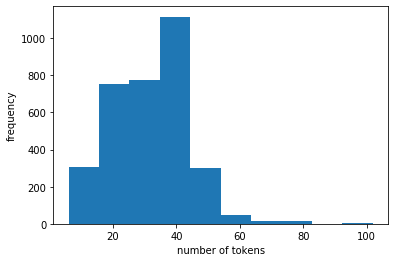

In [0]:
train_token_len = [len(x) for x in train_tokens]
train_token_len.extend([len(x) for x in dev_tokens])
plt.hist(train_token_len)
plt.xlabel("number of tokens")
plt.ylabel("frequency")
print(f"95 percentile of token lengths for training data: {np.percentile(train_token_len, 95)}")
print(f"max token length for training data: {np.max(train_token_len)}")

95 percentile of token lengths for test data: 50.0
max token length for test data: 77


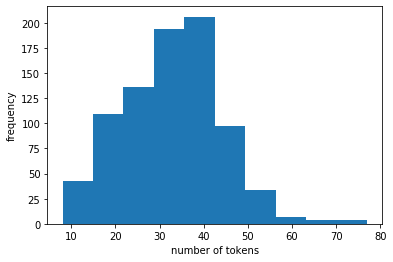

In [0]:
test_token_len = [len(x) for x in test_tokens]
plt.hist(test_token_len)
plt.xlabel("number of tokens")
plt.ylabel("frequency")
print(f"95 percentile of token lengths for test data: {np.percentile(test_token_len, 95)}")
print(f"max token length for test data: {np.max(test_token_len)}")

In [0]:
def pad_embeddings(example, max_len):
  example_len = example.shape[0]
  padding = np.zeros((max_len-example_len,768))
  example_padding = np.append(padding, example, axis =0)
  return (example_padding)

In [0]:
max_len = 102
train_dev_x_pad = np.array([pad_embeddings(x, max_len) for x in train_dev_x])

In [0]:
test_x_pad = np.array([pad_embeddings(x, max_len) for x in test_x])

In [0]:
train_dev_x_pad.shape

(3335, 102, 768)

In [0]:
test_x_pad.shape

(834, 102, 768)

In [0]:
#CNN with avg embeddings
embed_dim = 5
num_filters = [10, 10, 10, 10]
kernel_sizes = [5, 10, 15, 20]
dense_layer_dims = []
dropout_rate = 0.8

input_layer = tf.keras.layers.Input(shape=(102,768), name="input")

conv_layers_for_all_kernel_sizes = []
for kernel_size, filters in zip(kernel_sizes, num_filters):
    conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(input_layer)
    conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)

# Concat the feature maps from each different size.
layer = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

#layer = keras.layers.Dropout(rate=dropout_rate, name='dropout')(layer)

for dim in dense_layer_dims:  
  layer = keras.layers.Dense(dim, activation='relu')(layer)

classification_output = keras.layers.Dense(1, activation='sigmoid', name='sigmoid')(layer)

cnn_model = keras.Model(input_layer, classification_output)
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

cnn_model.reset_states()
cnn_model.fit(train_dev_x_pad, train_dev_y, validation_data=[test_x_pad, test_y], epochs=10)
cnn_model.summary()

Train on 3335 samples, validate on 834 samples
Epoch 1/10
3335/3335 [==============================] - 7s 2ms/sample - loss: 0.2157 - acc: 0.9463 - val_loss: 0.2369 - val_acc: 0.9077
Epoch 2/10
3335/3335 [==============================] - 4s 1ms/sample - loss: 0.1548 - acc: 0.9502 - val_loss: 0.2128 - val_acc: 0.9053
Epoch 3/10
3335/3335 [==============================] - 4s 1ms/sample - loss: 0.1530 - acc: 0.9475 - val_loss: 0.2238 - val_acc: 0.9065
Epoch 4/10
3335/3335 [==============================] - 4s 1ms/sample - loss: 0.1478 - acc: 0.9502 - val_loss: 0.2257 - val_acc: 0.9077
Epoch 5/10
3335/3335 [==============================] - 4s 1ms/sample - loss: 0.1397 - acc: 0.9496 - val_loss: 0.1929 - val_acc: 0.9125
Epoch 6/10
3335/3335 [==============================] - 4s 1ms/sample - loss: 0.1115 - acc: 0.9553 - val_loss: 0.1524 - val_acc: 0.9353
Epoch 7/10
3335/3335 [==============================] - 4s 1ms/sample - loss: 0.0855 - acc: 0.9664 - val_loss: 0.2023 - val_acc: 0.9113
E

In [0]:
test_prob = cnn_model.predict(test_x_pad)
test_pred = np.where(test_prob >=0.5, 1, 0)
print(f"accuracy: {np.round(accuracy_score(test_pred, test_y),4)*100}%")
print(f"f1-score: {np.round(f1_score(test_pred, test_y),4)*100}%")

accuracy: 95.32000000000001%
f1-score: 81.86%


In [0]:
cm = confusion_matrix(test_pred, test_y)
pd.DataFrame((cm/cm.sum())*100, columns=["pred neg","pred pos"], index=["true neg","true pos"]).round(2).astype(str).add('%')

,pred neg,pred pos
true neg,84.77%,0.48%
true pos,4.2%,10.55%


In [0]:
#LSTM with all embeddings
input_layer = tf.keras.layers.Input(shape=(102,768), name="input")
lstm_output = LSTM(100, input_shape=(768,102,), name="lstm")(input_layer)
classification_output = Dense(1, activation="sigmoid", name="sigmoid")(lstm_output)

lstm_model = Model(input_layer, classification_output)
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.reset_states()
lstm_model.fit(train_dev_x_pad, train_dev_y, validation_data=[test_x_pad, test_y], epochs=10)
lstm_model.summary()

Train on 3335 samples, validate on 834 samples
Epoch 1/10
3335/3335 [==============================] - 25s 8ms/sample - loss: 0.1719 - acc: 0.9430 - val_loss: 0.2257 - val_acc: 0.9101
Epoch 2/10
3335/3335 [==============================] - 24s 7ms/sample - loss: 0.1512 - acc: 0.9481 - val_loss: 0.2114 - val_acc: 0.9041
Epoch 3/10
3335/3335 [==============================] - 24s 7ms/sample - loss: 0.1396 - acc: 0.9472 - val_loss: 0.1888 - val_acc: 0.9149
Epoch 4/10
3335/3335 [==============================] - 24s 7ms/sample - loss: 0.0939 - acc: 0.9616 - val_loss: 0.1034 - val_acc: 0.9472
Epoch 5/10
3335/3335 [==============================] - 24s 7ms/sample - loss: 0.0541 - acc: 0.9796 - val_loss: 0.0834 - val_acc: 0.9676
Epoch 6/10
3335/3335 [==============================] - 25s 7ms/sample - loss: 0.0389 - acc: 0.9877 - val_loss: 0.0515 - val_acc: 0.9796
Epoch 7/10
3335/3335 [==============================] - 24s 7ms/sample - loss: 0.0320 - acc: 0.9886 - val_loss: 0.0556 - val_acc: 0

In [0]:
test_prob = lstm_model.predict(test_x_pad)
test_pred = np.where(test_prob >=0.5, 1, 0)
print(f"accuracy: {np.round(accuracy_score(test_pred, test_y),4)*100}%")
print(f"f1-score: {np.round(f1_score(test_pred, test_y),4)*100}%")

accuracy: 99.16%
f1-score: 96.34%


In [0]:
cm = confusion_matrix(test_pred, test_y)
pd.DataFrame((cm/cm.sum())*100, columns=["pred neg","pred pos"], index=["true neg","true pos"]).round(2).astype(str).add('%')

,pred neg,pred pos
true neg,88.13%,0.0%
true pos,0.84%,11.03%


In [0]:
#logistic regression
param_grid = {"C": np.linspace(0.0001, 100, 30),
              "penalty": ["l1", "l2", "elasticnet"],
              "class_weight": ["balanced", None]}
lr = LogisticRegression(random_state=0)
search = GridSearchCV(lr, param_grid, cv=3, scoring='f1')
search.fit(train_dev_x2, train_dev_y)
search.best_params_

{'C': 3.4483724137931033, 'class_weight': None, 'penalty': 'l2'}

In [0]:
train_pred = search.predict(train_dev_x2)
print(f"accuracy: {np.round(accuracy_score(train_pred, train_dev_y),4)*100}%")
print(f"f1-score: {np.round(f1_score(train_pred, train_dev_y),4)*100}%")

accuracy: 98.08%
f1-score: 91.42%


In [0]:
cm = confusion_matrix(train_pred, train_dev_y)
pd.DataFrame((cm/cm.sum())*100, columns=["pred neg","pred pos"], index=["true neg","true pos"]).round(2).astype(str).add('%')

,pred neg,pred pos
true neg,87.86%,0.84%
true pos,1.08%,10.22%


In [0]:
test_pred = search.predict(test_x2)
print(f"accuracy: {np.round(accuracy_score(test_pred, test_y),4)*100}%")
print(f"f1-score: {np.round(f1_score(test_pred, test_y),4)*100}%")

accuracy: 91.61%
f1-score: 61.11%


In [0]:
cm = confusion_matrix(test_pred, test_y)
pd.DataFrame((cm/cm.sum())*100, columns=["pred neg","pred pos"], index=["true neg","true pos"]).round(2).astype(str).add('%')

,pred neg,pred pos
true neg,85.01%,4.44%
true pos,3.96%,6.59%


In [0]:
deep_model = keras.Sequential([
                               keras.layers.Dense(5, input_shape=(768,), activation='relu'),
                               keras.layers.Dense(5, input_shape=(5,), activation='relu'),
                               keras.layers.Dense(1, activation='sigmoid')
])

deep_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

deep_model.fit(train_x2, train_y, epochs=50)

ValueError: ignored

In [0]:
train_prob = deep_model.predict(train_x)
train_pred = np.where(train_prob >=0.5, 1, 0)
print(f"accuracy: {np.round(accuracy_score(train_pred, train_y),4)*100}%")
print(f"f1-score: {np.round(f1_score(train_pred, train_y),4)*100}%")

In [0]:
test_prob = deep_model.predict(test_x)
test_pred = np.where(test_prob >=0.5, 1, 0)
print(f"accuracy: {np.round(accuracy_score(test_pred, test_y),4)*100}%")
print(f"f1-score: {np.round(f1_score(test_pred, test_y),4)*100}%")